In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('data/churn_data.csv')

In [3]:
#change dtype of 'TotalCharges' from object to numeric
#if there is an error, because the value has a space (" "), we use --> errors='coerce'
total_charges = pd.to_numeric(df.TotalCharges, errors='coerce')

In [4]:
#getting null (missing) values
df[total_charges.isnull()][['customerID', 'TotalCharges']]

,customerID,TotalCharges
488,4472-LVYGI,
753,3115-CZMZD,
936,5709-LVOEQ,
1082,4367-NUYAO,
1340,1371-DWPAZ,
3331,7644-OMVMY,
3826,3213-VVOLG,
4380,2520-SGTTA,
5218,2923-ARZLG,
6670,4075-WKNIU,


In [5]:
#set missing values to zero
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
df.TotalCharges = df.TotalCharges.fillna(0)

In [6]:
#column names & string values: lowercasing everything and replace spaces with underscore
df.columns = df.columns.str.lower().str.replace(' ', '_')
string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [7]:
df.head(3)

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-vhveg,female,0,yes,no,1,no,no_phone_service,dsl,no,...,no,no,no,no,month-to-month,yes,electronic_check,29.85,29.85,no
1,5575-gnvde,male,0,no,no,34,yes,no,dsl,yes,...,yes,no,no,no,one_year,no,mailed_check,56.95,1889.50,no
2,3668-qpybk,male,0,no,no,2,yes,no,dsl,yes,...,no,no,no,no,month-to-month,yes,mailed_check,53.85,108.15,yes


In [8]:
#change target variable from object to integer (if yes, then 1; if no, then 0)
df.churn = (df.churn == 'yes').astype(int)

In [9]:
#splitting the dataset in different subsets
from sklearn.model_selection import train_test_split


In [10]:
#shuffling the data of df and splitting it into 2 sets
#df_train_full (80%), df_test(20%)
#random_state guarantees that the data is always shuffled in the same way
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [11]:
#take df_train_full and split it into train and val
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=11)
#save target variable in a matrix array
y_train = df_train.churn.values
y_val = df_val.churn.values
#delete target variable from training and validation set
del df_train['churn']
del df_val['churn']

<b>Feature Engineering</b><br>
We compare 3 scenarios:<br>
* Scenario 1: All features are included 
* Scenario 2: The two least important features 'gender' and 'phoneservice' are excluded
* Scenario 3: The most important feature 'contract' is exluded<br><br>
The cell below gives the accuracy for each Scenario


In [12]:
#create variable lists
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
'phoneservice', 'multiplelines', 'internetservice',
'onlinesecurity', 'onlinebackup', 'deviceprotection',
'techsupport', 'streamingtv', 'streamingmovies',
'contract', 'paperlessbilling', 'paymentmethod']

categ_ex_1 = ['seniorcitizen', 'partner', 'dependents',
'multiplelines', 'internetservice',
'onlinesecurity', 'onlinebackup', 'deviceprotection',
'techsupport', 'streamingtv', 'streamingmovies',
'contract', 'paperlessbilling', 'paymentmethod']

categ_ex_2 = ['gender', 'seniorcitizen', 'partner', 'dependents',
'phoneservice', 'multiplelines', 'internetservice',
'onlinesecurity', 'onlinebackup', 'deviceprotection',
'techsupport', 'streamingtv', 'streamingmovies',
'paperlessbilling', 'paymentmethod']

numerical = ['tenure', 'monthlycharges', 'totalcharges']

lists = [categorical, categ_ex_1, categ_ex_2]
scenario = ['Scenario 1:', 'Scenario 2:', 'Scenario 3:']

In [13]:
x = 0
for L in lists:
    def prepare_X(df, categ):
        #convert training set to dictionary
        train_dict = df[categ + numerical].to_dict(orient='rows')
        from sklearn.feature_extraction import DictVectorizer
        dv = DictVectorizer(sparse=False)
        dv.fit(train_dict)
        #use 'transform' method to convert dictionaries to matrix
        X = dv.transform(train_dict)
        return X
    
    #train logictic regression model
    from sklearn.linear_model import LogisticRegression
    #train model by calling the 'fit' method
    #X_train is derived from training set (besides we also have validation and testing set)
    model = LogisticRegression(solver='liblinear', random_state = 1)
    model.fit(prepare_X(df_train, L), y_train)
    
    def prepare_val(df, categ):
        #convert training set to dictionary
        train_dict = df[categ + numerical].to_dict(orient='rows')
        from sklearn.feature_extraction import DictVectorizer
        dv_new = DictVectorizer(sparse=False)
        dv_new.fit(train_dict)
        #use 'transform' method to convert dictionaries to matrix
        X = dv_new.transform(train_dict)
        return X
    
    #use the model to predict the target variable
    y_pred = model.predict_proba(prepare_val(df_val, L))[:, 1]
    y_pred >= 0.5
    churn = y_pred >= 0.5
    print('Accuracy for', scenario[x], (y_val == churn).mean())
    x += 1

Accuracy for Scenario 1: 0.8016129032258065
Accuracy for Scenario 2: 0.8026881720430108
Accuracy for Scenario 3: 0.7973118279569893


In [14]:
from sklearn.metrics import accuracy_score

In [15]:
#loop over different thresholds and see what has the best accuracy
#a threshold of 0.5 gives us the best accuracy
thresholds = np.linspace(0, 1, 11) #this gives 11 numbers starting with 0.0, 0.1, 0.2, ...
for t in thresholds:
    #compute accuracy
    churn = y_pred >= t
    acc = accuracy_score(y_val, churn)
    #print results
    print('%0.2f %0.3f' % (t, acc))

0.00 0.261
0.10 0.563
0.20 0.697
0.30 0.751
0.40 0.791
0.50 0.797
0.60 0.791
0.70 0.778
0.80 0.748
0.90 0.739
1.00 0.739


In [16]:
thresholds = np.linspace(0, 1, 21)
accuracies = []
for t in thresholds:
    acc = accuracy_score(y_val, y_pred >= t)
    accuracies.append(acc)

Text(0, 0.5, 'Threshold')

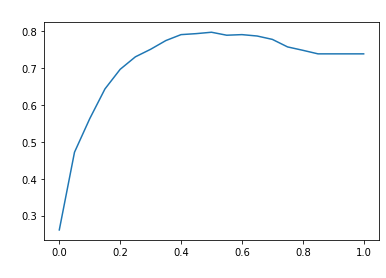

In [17]:
plt.plot(thresholds, accuracies)
plt.title('Threshold vs Accuracy', color='white')
plt.xlabel('Threshold', color='white')
plt.ylabel('Threshold', color='white')

Applying that to small model

In [18]:
small_subset = ['contract', 'tenure', 'totalcharges']
#convert to dictionary
train_dict_small = df_train[small_subset].to_dict(orient='rows')
#make use of DictVectorizer to perform one hot encoding
from sklearn.feature_extraction import DictVectorizer
dv_small = DictVectorizer(sparse=False)
#use fit method to apply DictVectorizer to dictionary
dv_small.fit(train_dict_small)
#transform dictionary to matrix array
X_small_train = dv_small.transform(train_dict_small)


In [19]:
model_small = LogisticRegression(solver='liblinear', random_state=1)
model_small.fit(X_small_train, y_train)

#train a simpler model
#apply one-hot-encoding to validation set
val_dict_small = df_val[small_subset].to_dict(orient='rows')
dv_small.fit(val_dict_small)
X_small_val = dv_small.transform(val_dict_small)
#predict churn using this small model
y_pred_small = model_small.predict_proba(X_small_val)[:, 1]
churn_small = y_pred_small >= 0.5
#calculate accuracy
accuracy_score(y_val, churn_small)

0.7672043010752688

Is an accuracy of 0.77 now a good value? We need to compare it. One possibility could be<br>
the <b>Dummy Baseline</b>, what
* always predicts the majority class: here "no churn (False)"

In [20]:
#making a baseline prediction
#get number of customers in validation set
size_val = len(y_val)
#create array with only false elements
baseline = np.repeat(False, size_val)

In [21]:
#check the accuracy
accuracy_score(baseline, y_val)

0.7387096774193549

the smaller model is only 2% better and the big model is only 6% better than the dummy baseline.<br>
We need another metric: the <b>Confusion Table</b><br>
<img src="data/pic-9.png" width=600 align="left">

what the model is doing with the validation set:<br>
<img src="data/pic-10.png" width=400 align="left">

In [22]:
#calculate the 4 outcomes
#make prediction at threshold 0.5
t = 0.5
predict_churn = (y_pred >= t)
predict_no_churn = (y_pred < t)

#get the actual target values
actual_churn = (y_val == 1)
actual_no_churn = (y_val == 0)

#calculate true and false positives
true_positive = (predict_churn & actual_churn).sum()
false_positive = (predict_churn & actual_no_churn).sum()

#calculate false and true negatives
#the logical "and" operator only evaluates to true if both values are true
false_negative = (predict_no_churn & actual_churn).sum()
true_negative = (predict_no_churn & actual_no_churn).sum()


Generating 2 arrays out of the predicated target values:<br>
<img src="data/pic-11.png" width=600 align="left">

Generating 2 arrays out of the actual target values:<br>
<img src="data/pic-12.png" width=600 align="left">

In [27]:
#put all 4 values in one numpy array
confusion_table = np.array(
[[true_negative, false_positive],
[false_negative, true_positive]])
confusion_table

array([[1208,  166],
       [ 211,  275]])

In [28]:
#take fractions to better understand the values
confusion_table / confusion_table.sum()

array([[0.64946237, 0.08924731],
       [0.11344086, 0.14784946]])

In [29]:
#produce confusion table out of the small table

#calculate the 4 outcomes
#make prediction at threshold 0.5
t = 0.5
predict_churn = (y_pred_small >= t)
predict_no_churn = (y_pred_small < t)

#get the actual target values
actual_churn = (y_val == 1)
actual_no_churn = (y_val == 0)

#calculate true and false positives
true_positive = (predict_churn & actual_churn).sum()
false_positive = (predict_churn & actual_no_churn).sum()

#calculate false and true negatives
#the logical "and" operator only evaluates to true if both values are true
false_negative = (predict_no_churn & actual_churn).sum()
true_negative = (predict_no_churn & actual_no_churn).sum()


In [30]:
#put all 4 values in one numpy array
confusion_table = np.array(
[[true_negative, false_positive],
[false_negative, true_positive]])
confusion_table

array([[1189,  185],
       [ 248,  238]])

In [31]:
#take fractions to better understand the values
confusion_table / confusion_table.sum()

array([[0.63924731, 0.09946237],
       [0.13333333, 0.12795699]])

<b>Precision and Recall</b><br>
metrics that help us to better understand the quality of the model<br>
in case of class imbalance.

<b>Precision</b>: How many of the positive predictions are correct<br>
* P = TP/(TP + FP)

<b>Recall</b>: Positive predictions divided by the number of all positive examples<br>
FN stands for a positive case, that was predicted negative<br>
* R = TP/(TP + FN)

<img src="data/pic-13.png" width=600 align="left">

* precision helps us to understand how many customers received promotional messages per mmistake (actually they are not going to churn)
* recall helps us to understand how many of the churning customers haven't been identified by the model